In [184]:
import numpy as np

# Define the file path and data type
file_path = 'Test_Data/rx_data_raw_SN04_UHF240125T013000'  # Replace with the actual file path
dtype = np.complex64  # 32-bit complex data type

# Calculate the number of elements to read for 1 GB of data
bytes_to_read = 8 * 1024 * 1024 * 1024  # 1 GB in bytes
complex_size = 64
elements_to_read = bytes_to_read // complex_size

# Read the first gigabyte of data
data = np.fromfile(file_path, dtype=dtype, count=elements_to_read)

# If you want to reshape the data into a 1D array of complex numbers, you can do:
data = data.reshape(-1)

len(data) * complex_size / 8, data


(1073741824.0,
 array([-0.015625 +0.j       , -0.015625 +0.j       ,
        -0.015625 -0.0078125j, ..., -0.546875 +0.j       ,
        -0.2890625+0.1015625j, -0.40625  -0.0390625j], dtype=complex64))

array([ 0.55918106,  0.59283446,  0.6286481 , ..., -0.04004054,
        0.00532761,  0.03774603])

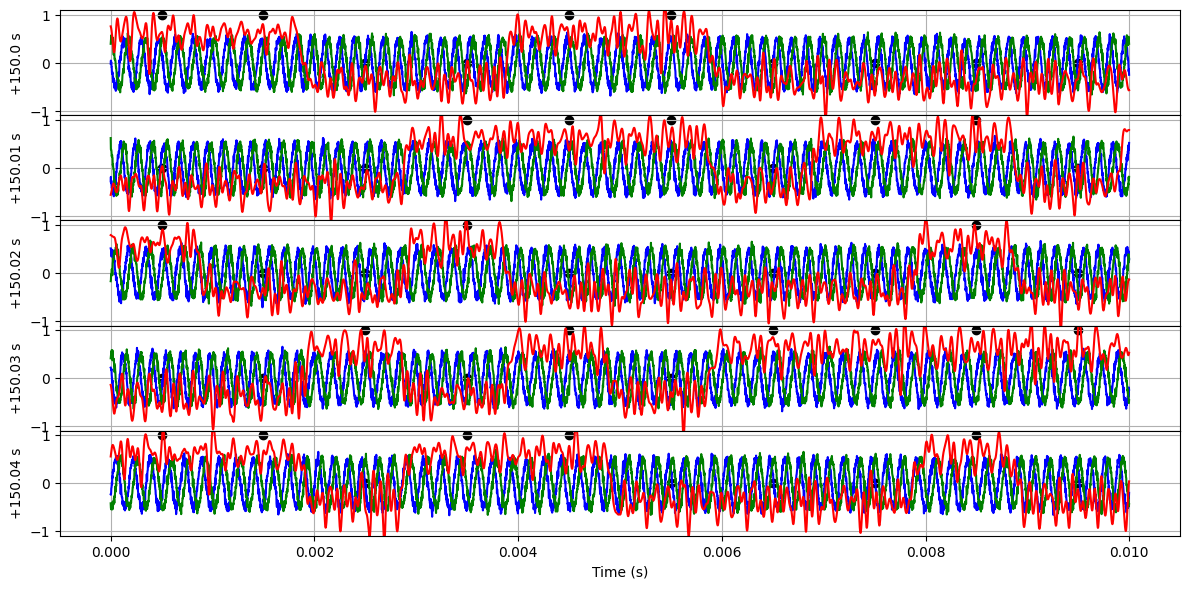

In [185]:
import matplotlib.pyplot as plt
import math
from scipy.signal import butter, lfilter, freqz

# Assuming you have loaded your complex data into 'data' as shown in the previous code

# Calculate the time values based on the sample rate (500 ksps)
sample_rate = 500e3  # 500 ksps
time = np.arange(len(data)) / sample_rate
fsk_deviation = 1.1e3
symbol_rate = 1e3 # symbols per second
samples_per_symbol = sample_rate / symbol_rate

# Separate real and imaginary parts for plotting
real_part = data.real
imaginary_part = data.imag

# Filter and plot the demodulated data
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

cutoff = 10e3 # Hz
filtered_data = butter_lowpass_filter(data, cutoff, sample_rate, 5)
demodulated_data = 0.5 * sample_rate * (1 / (math.pi * fsk_deviation)) * np.angle(filtered_data[0:-1] * np.conj(filtered_data[1:]))
demodulated_data += 6

# Create a single figure with num_intervals subplots for interval_duration
start_offset = 150
num_intervals = 5
interval_duration = 0.01  # seconds
total_duration = num_intervals * interval_duration  # seconds

fig, axes = plt.subplots(num_intervals, 1, figsize=(12, 6), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i, ax in enumerate(axes):
    start_time = i * interval_duration + start_offset
    end_time = (i + 1) * interval_duration + start_offset
    start_sample = int(start_time * sample_rate)
    end_sample = int(end_time * sample_rate)
    
    ax.plot(time[start_sample:end_sample] - time[start_sample], 
        real_part[start_sample:end_sample], label='Real Part', color='blue')
    ax.plot(time[start_sample:end_sample] - time[start_sample], 
        imaginary_part[start_sample:end_sample], label='Imaginary Part', color='green')
    ax.plot(time[start_sample:end_sample] - time[start_sample], 
        demodulated_data[start_sample:end_sample], label='Demodulated Data', color='red')
    ax.set_ylabel('+' + str(start_time) + ' s')
    #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
    ax.grid(True)
    ax.set_ylim(-1, 1)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([1, 0, '1/-1'])
    # ax.legend()

display(demodulated_data[start_sample:end_sample])

# Manual Timing Interpreter
tau = 0.001 - 0.000
tau_in_samples = int(tau * sample_rate)

kernel = np.ones(int(samples_per_symbol))
def decimate_convolve(a, kernel, tau_in_samples):
    samples_per_symbol = len(kernel)
    a = a[tau_in_samples:]
    a = a[:len(a) - len(a) % int(samples_per_symbol)]
    a = np.reshape(a, (-1, int(samples_per_symbol)))
    return np.sum(a * kernel[np.newaxis,:], 1) / samples_per_symbol

decision_values = decimate_convolve(demodulated_data, kernel, tau_in_samples)
bits = np.greater(decision_values, np.zeros_like(decision_values))

# Plot the data
time = np.arange(len(bits)) / symbol_rate

for i, ax in enumerate(axes):
    start_time = i * interval_duration + start_offset
    end_time = (i + 1) * interval_duration + start_offset
    start_sample = int(start_time * symbol_rate) - 1
    end_sample = int(end_time * symbol_rate) - 1

    ax.scatter(time[start_sample:end_sample] - time[start_sample] + tau - 1/(2*symbol_rate), 
        bits[start_sample:end_sample], label='Data', color='black')
    ax.set_ylabel('+' + str(start_time) + ' s')
    #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
    ax.grid(True)
    ax.set_ylim(-1.1, 1.1)
    # ax.legend()
symbol_tau = tau
plt.xlabel('Time (s)')
#plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()


In [186]:
max_errors_per_clip_range=5

with open("tx_data", 'rb') as transmitted_binary:
    transmitted_array = np.asarray(bytearray(transmitted_binary.read()))

transmitted_bits = np.unpackbits(transmitted_array)
received_bits = 1 - bits.astype('uint8')

transmitted_bits, received_bits
number_of_errors = len(received_bits)
tau_min = 0

clip_range = 1000 # bits
ith_kbit = -1

total_number_of_clips = int(len(transmitted_bits)/clip_range)

for i in range(0, total_number_of_clips):
    clipped_transmitted_bits = transmitted_bits[i*clip_range:(i+1)*(clip_range)]
    min_number_of_errors_per_i = clip_range
    # Search for the minimum number of errors caused by the start of the data sequence
    for tau in range(len(received_bits) - len(clipped_transmitted_bits)):
        error_bits = np.abs(np.ndarray.astype(clipped_transmitted_bits, np.byte) \
            - np.ndarray.astype(received_bits[tau:tau+len(clipped_transmitted_bits)], np.byte))
        temp = np.sum(error_bits)
        if temp < min_number_of_errors_per_i:
            min_number_of_errors_per_i = temp

        if temp < number_of_errors:
            number_of_errors = temp
            tau_min = tau

        if temp < max_errors_per_clip_range:
            number_of_errors = temp
            tau_min = tau
            break
    print('{0}/{1}'.format(min_number_of_errors_per_i,clip_range) \
            + ' errors found in clip index i=' + str(i) \
            + '/' + str(total_number_of_clips), end='\r')
    
    if number_of_errors < max_errors_per_clip_range:
        ith_kbit = i
        break

# Once the first fully correct clip range is found, 
# look for the last block that has less than max_errors_per_clip_range
end_number_of_errors = clip_range
end_tau = tau_min
total_errors = 0
for tau in range(tau_min, len(received_bits) - len(clipped_transmitted_bits), clip_range):
    clipped_transmitted_bits = transmitted_bits[i*clip_range:(i+1)*(clip_range)]
    error_bits = np.abs(np.ndarray.astype(clipped_transmitted_bits, np.byte) \
        - np.ndarray.astype(received_bits[tau:tau+len(clipped_transmitted_bits)], np.byte))
    temp = np.sum(error_bits)

    end_number_of_errors = temp
    end_tau = tau + clip_range

    if temp > max_errors_per_clip_range:
        break
    else:
        total_errors += temp

    i += 1

# min_error_bits = np.abs(np.ndarray.astype(transmitted_bits, np.byte) \
#         - np.ndarray.astype(received_bits[tau_min:tau_min+len(transmitted_bits)], np.byte))

bit_error_rate = total_errors / (end_tau - tau_min)

print()
print('TX Data Length: ' + str(len(transmitted_bits)))
print('RX Data Length: ' + str(len(received_bits)))
print('Clean data found from {0} to {1}, for a total length {2}'.format(tau_min, end_tau, (end_tau - tau_min)))
print('Errors in the first clip range {0}'.format(number_of_errors))
print('Errors in the last clip range {0}'.format(end_number_of_errors))
print('Bit Error Rate (BER): ' + str(bit_error_rate))
print()
print(str(received_bits[tau_min:tau_min+40]))
print(str(transmitted_bits[ith_kbit*clip_range:ith_kbit*clip_range+40]))

bit_error_rate, number_of_errors, len(transmitted_bits), len(received_bits), tau_min

0/1000 errors found in clip index i=9/8640000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from 118415 to 182415, for a total length 64000
Errors in the first clip range 0
Errors in the last clip range 14
Bit Error Rate (BER): 7.8125e-05

[0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0
 1 0 0]
[0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0
 1 0 0]


(7.8125e-05, 0, 86400008, 268434, 118415)

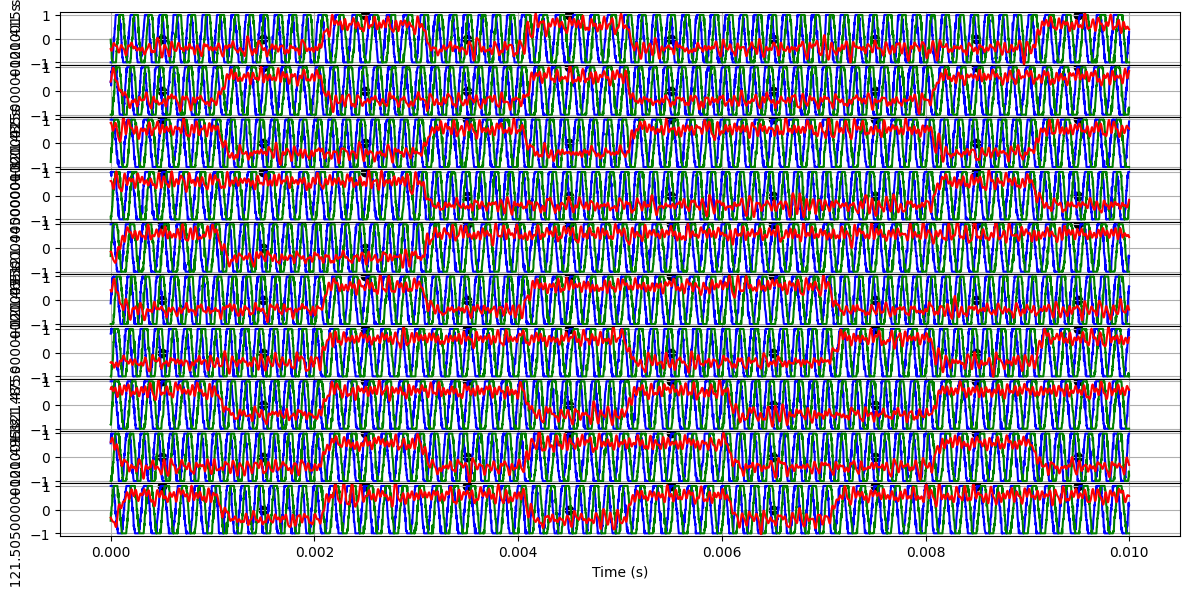

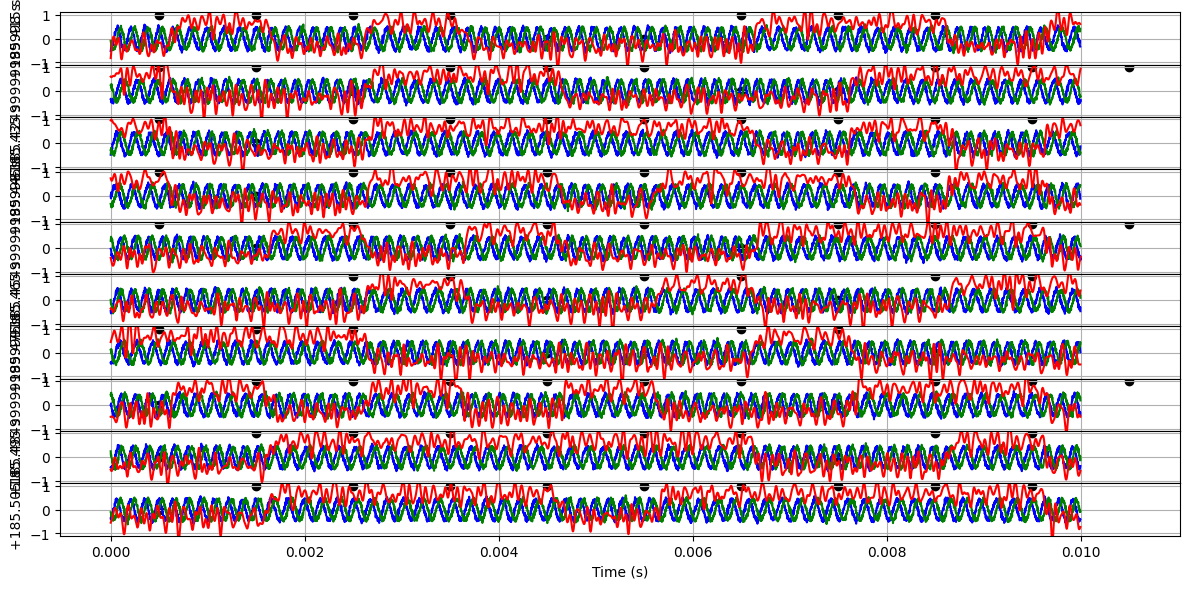

In [193]:
for val in [tau_min, end_tau]:
    # Create a single figure with num_intervals subplots for interval_duration
    start_offset = (val+3000) / symbol_rate
    num_intervals = 10
    interval_duration = 0.01  # seconds
    total_duration = num_intervals * interval_duration  # seconds
    time = np.arange(len(data)) / sample_rate

    fig, axes = plt.subplots(num_intervals, 1, figsize=(12, 6), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})

    for i, ax in enumerate(axes):
        start_time = i * interval_duration + start_offset
        end_time = (i + 1) * interval_duration + start_offset
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        
        ax.plot(time[start_sample:end_sample] - time[start_sample], 
            real_part[start_sample:end_sample], label='Real Part', color='blue')
        ax.plot(time[start_sample:end_sample] - time[start_sample], 
            imaginary_part[start_sample:end_sample], label='Imaginary Part', color='green')
        ax.plot(time[start_sample:end_sample] - time[start_sample], 
            demodulated_data[start_sample:end_sample], label='Demodulated Data', color='red')
        ax.set_ylabel('+' + str(start_time) + ' s')
        #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
        ax.grid(True)
        ax.set_ylim(-1, 1)
        #ax.set_xticklabels([])
        #ax.set_yticklabels([1, 0, '1/-1'])
        # ax.legend()

    # Plot the data
    time = np.arange(len(bits)) / symbol_rate

    for i, ax in enumerate(axes):
        start_time = i * interval_duration + start_offset
        end_time = (i + 1) * interval_duration + start_offset
        start_sample = int(start_time * symbol_rate) - 1
        end_sample = int(end_time * symbol_rate) - 1

        ax.scatter(time[start_sample:end_sample] - time[start_sample] + symbol_tau - 1/(2*symbol_rate), 
            bits[start_sample:end_sample], label='Data', color='black')
        ax.set_ylabel('+' + str(start_time) + ' s')
        #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
        ax.grid(True)
        ax.set_ylim(-1.1, 1.1)
        # ax.legend()

    plt.xlabel('Time (s)')
    #plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

In [188]:
# from scipy.signal import resample_poly

# # Symbol sync, using what we did in sync chapter
# samples = data # for the sake of matching the sync chapter, https://pysdr.org/content/sync.html#sync-chapter

# # Decimate the data
# decimation_rate = 20
# samples = samples[::decimation_rate]
# sample_rate = sample_rate / decimation_rate 

# # Interpolate using a polyphase filter
# interpolation_rate = 32
# samples_interpolated = resample_poly(samples, interpolation_rate, 1) 
# # we'll use 32 as the interpolation factor, arbitrarily chosen, seems to work better than 16
# samples_per_symbol = sample_rate / symbol_rate

# # Implementation of the Mueller-Mueller timing estimator
# mu = 0.01 # initial estimate of phase of sample
# out = np.zeros(len(samples) + 10, dtype=np.complex64)
# out_rail = np.zeros(len(samples) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
# i_in = 0 # input samples index
# i_out = 2 # output index (let first two outputs be 0)
# while i_out < len(samples) and i_in+32 < len(samples):
#     out[i_out] = samples_interpolated[i_in*32 + int(mu*32)] # grab what we think is the "best" sample
#     out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
#     x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
#     y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
#     mm_val = np.real(y - x)
#     mu += samples_per_symbol + 0.01*mm_val
#     i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
#     mu = mu - np.floor(mu) # remove the integer part of mu
#     i_out += 1 # increment output index
# x = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)

# sample_rate = symbol_rate

# # Demod BPSK
# bits = (np.real(x) > 0).astype(int) # 1's and 0's

# # # Differential decoding, so that it doesn't matter whether our BPSK was 180 degrees rotated without us realizing it
# # bits = (bits[1:] - bits[0:-1]) % 2
# # bits = bits.astype(np.uint8) # for decoder

# # Plot the data
# fig, axes = plt.subplots(num_intervals, 1, figsize=(12, 6), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})
# time = np.arange(len(x)) / sample_rate

# for i, ax in enumerate(axes):
#     start_time = i * interval_duration + start_offset
#     end_time = (i + 1) * interval_duration + start_offset
#     start_sample = int(start_time * sample_rate)
#     end_sample = int(end_time * sample_rate)
    
#     ax.plot(time[start_sample:end_sample] - time[start_sample], 
#         np.real(x[start_sample:end_sample]), label='Real Part', color='blue', linestyle=None)
#     ax.plot(time[start_sample:end_sample] - time[start_sample], 
#         np.imag(x[start_sample:end_sample]), label='Imaginary Part', color='green', linestyle=None)
#     ax.plot(time[start_sample:end_sample] - time[start_sample], 
#         np.imag(bits[start_sample:end_sample]), label='Data', color='black', linestyle=None)
#     ax.set_ylabel('+' + str(start_time) + ' s')
#     #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
#     ax.grid(True)
#     ax.set_ylim(-1, 1)
#     # ax.legend()

# plt.xlabel('Time (s)')
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# plt.show()

In [189]:
len(x) / 268.435456, len(bits), len(time), start_sample, end_sample, sample_rate, len(data)/500e3

(999.990850687027, 268434, 268434, 185504, 185514, 500000.0, 268.435456)